In [11]:
import os
import librosa
import numpy as np
import soundfile as sf
from pydub import AudioSegment
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [12]:
os.makedirs('../data/processed', exist_ok=True)

In [13]:
def convert_mp3_to_wav(mp3_path, wav_path, sample_rate=16000):
    """Convert MP3 to WAV at 16kHz (YAMNet requirement)"""
    audio = AudioSegment.from_mp3(mp3_path)
    audio = audio.set_frame_rate(sample_rate)
    audio = audio.set_channels(1)  # Mono
    audio.export(wav_path, format='wav')
    return wav_path

def normalize_audio(audio_data):
    """Normalize audio to [-1, 1] range"""
    max_val = np.abs(audio_data).max()
    if max_val > 0:
        return audio_data / max_val
    return audio_data

def trim_silence(audio_data, sr, top_db=20):
    """Trim silence from beginning and end"""
    trimmed, _ = librosa.effects.trim(audio_data, top_db=top_db)
    return trimmed

def create_fixed_length_chunks(audio_data, sr, chunk_duration=5.0):
    """
    Split audio into fixed-length chunks
    YAMNet expects variable length, but we create chunks for consistency
    """
    chunk_samples = int(chunk_duration * sr)
    chunks = []
    
    # If audio is shorter than chunk_duration, pad it
    if len(audio_data) < chunk_samples:
        padded = np.pad(audio_data, (0, chunk_samples - len(audio_data)), mode='constant')
        chunks.append(padded)
    else:
        # Split into overlapping chunks (50% overlap for data augmentation)
        hop_length = chunk_samples // 2
        for i in range(0, len(audio_data) - chunk_samples + 1, hop_length):
            chunk = audio_data[i:i + chunk_samples]
            chunks.append(chunk)
    
    return chunks

def add_noise(audio_data, noise_factor=0.005):
    """Add random noise for augmentation"""
    noise = np.random.randn(len(audio_data))
    augmented = audio_data + noise_factor * noise
    return augmented

def time_shift(audio_data, sr, shift_max=0.2):
    """Shift audio in time"""
    shift = np.random.randint(int(sr * -shift_max), int(sr * shift_max))
    return np.roll(audio_data, shift)

def pitch_shift(audio_data, sr, n_steps=2):
    """Shift pitch up or down"""
    return librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=n_steps)

In [14]:
def process_audio_file(input_path, output_dir, class_name, 
                       apply_augmentation=True, chunk_duration=5.0):
    """Process a single audio file"""
    # Load audio at 16kHz
    audio, sr = librosa.load(input_path, sr=16000)
    
    # Normalize
    audio = normalize_audio(audio)
    
    # Trim silence
    audio = trim_silence(audio, sr)
    
    # Create chunks
    chunks = create_fixed_length_chunks(audio, sr, chunk_duration)
    
    processed_files = []
    base_filename = os.path.splitext(os.path.basename(input_path))[0]
    
    # Save original chunks
    for i, chunk in enumerate(chunks):
        output_path = os.path.join(output_dir, f"{base_filename}_chunk{i}.wav")
        sf.write(output_path, chunk, sr)
        processed_files.append(output_path)
    
    # Apply augmentation if requested
    if apply_augmentation and len(chunks) > 0:
        # Use first chunk for augmentation
        chunk = chunks[0]
        
        # Noise augmentation
        noisy = add_noise(chunk)
        output_path = os.path.join(output_dir, f"{base_filename}_noisy.wav")
        sf.write(output_path, noisy, sr)
        processed_files.append(output_path)
        
        # Time shift augmentation
        shifted = time_shift(chunk, sr)
        output_path = os.path.join(output_dir, f"{base_filename}_shifted.wav")
        sf.write(output_path, shifted, sr)
        processed_files.append(output_path)
        
        # Pitch shift augmentation
        pitched = pitch_shift(chunk, sr, n_steps=np.random.choice([-2, 2]))
        output_path = os.path.join(output_dir, f"{base_filename}_pitched.wav")
        sf.write(output_path, pitched, sr)
        processed_files.append(output_path)
    
    return processed_files

def process_dataset(input_dir='../data/raw', output_dir='../data/processed', 
                   apply_augmentation=True):
    """Process entire dataset"""
    dataset_info = {
        'classes': [],
        'files': {},
        'statistics': {}
    }
    
    for class_name in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_input_path):
            continue
        
        print(f"\nProcessing class: {class_name}")
        dataset_info['classes'].append(class_name)
        
        # Create output directory for this class
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)
        
        # Process all audio files in this class
        audio_files = [f for f in os.listdir(class_input_path) if f.endswith('.mp3')]
        dataset_info['files'][class_name] = []
        
        for audio_file in tqdm(audio_files, desc=f"Processing {class_name}"):
            input_path = os.path.join(class_input_path, audio_file)
            
            try:
                processed = process_audio_file(
                    input_path, 
                    class_output_path, 
                    class_name,
                    apply_augmentation=apply_augmentation
                )
                dataset_info['files'][class_name].extend(processed)
            except Exception as e:
                print(f"Error processing {audio_file}: {e}")
        
        # Statistics
        dataset_info['statistics'][class_name] = {
            'original_files': len(audio_files),
            'processed_files': len(dataset_info['files'][class_name])
        }
    
    return dataset_info


Configuration:
- Target sample rate: 16kHz
- Audio normalization: Enabled
- Silence trimming: Enabled
- Chunk duration: 5 seconds
- Augmentation: Enabled (noise, time shift, pitch shift)

Processing class: car_honk


Processing car_honk: 100%|██████████| 6/6 [00:00<00:00, 12.19it/s]



Processing class: cat


Processing cat: 100%|██████████| 6/6 [00:00<00:00, 12.80it/s]



Processing class: dog


Processing dog: 100%|██████████| 6/6 [00:00<00:00, 11.93it/s]



Processing class: police_siren


Processing police_siren: 100%|██████████| 6/6 [00:00<00:00, 16.31it/s]



PREPROCESSING STATISTICS

car_honk:
  Original files: 6
  Processed files: 24
  Augmentation factor: 4.0x

cat:
  Original files: 6
  Processed files: 24
  Augmentation factor: 4.0x

dog:
  Original files: 6
  Processed files: 25
  Augmentation factor: 4.2x

police_siren:
  Original files: 6
  Processed files: 24
  Augmentation factor: 4.0x


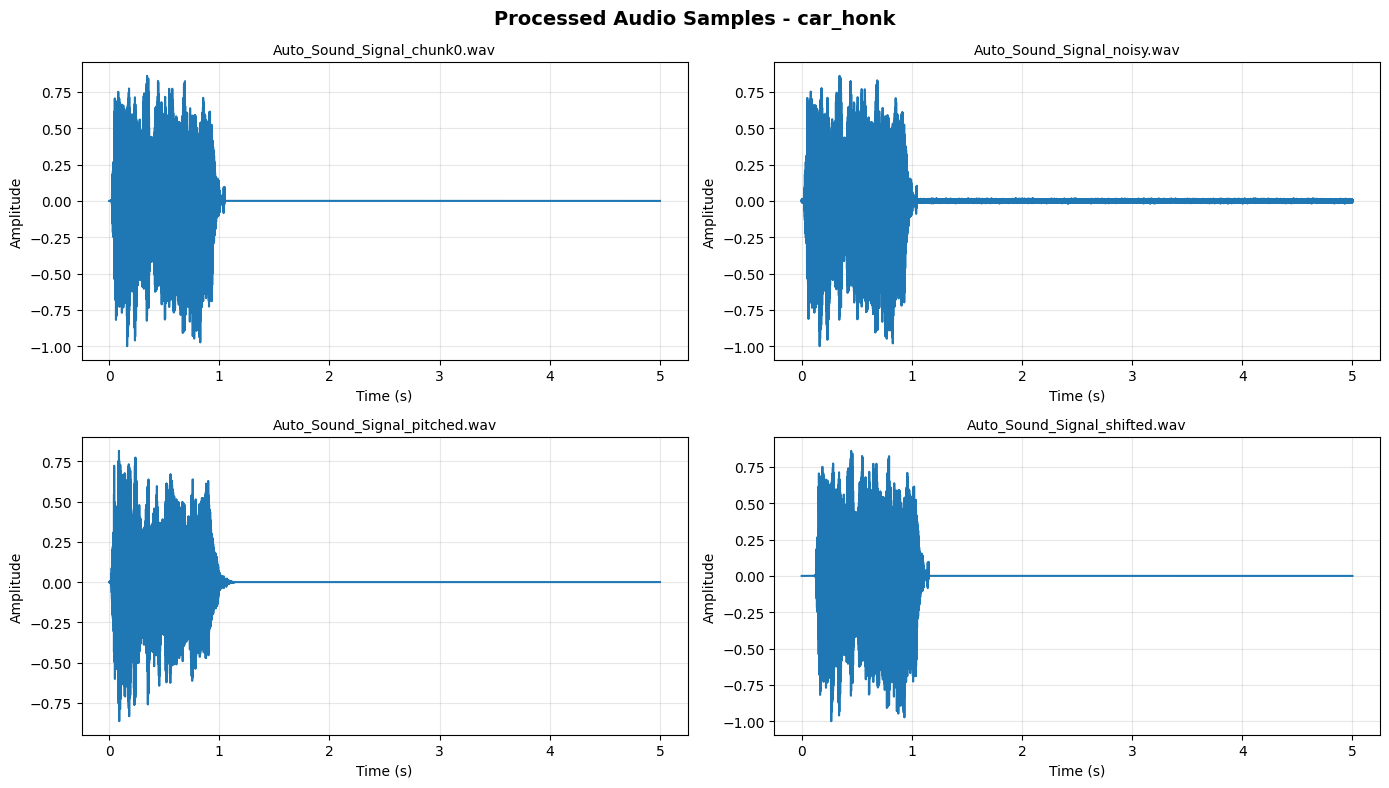

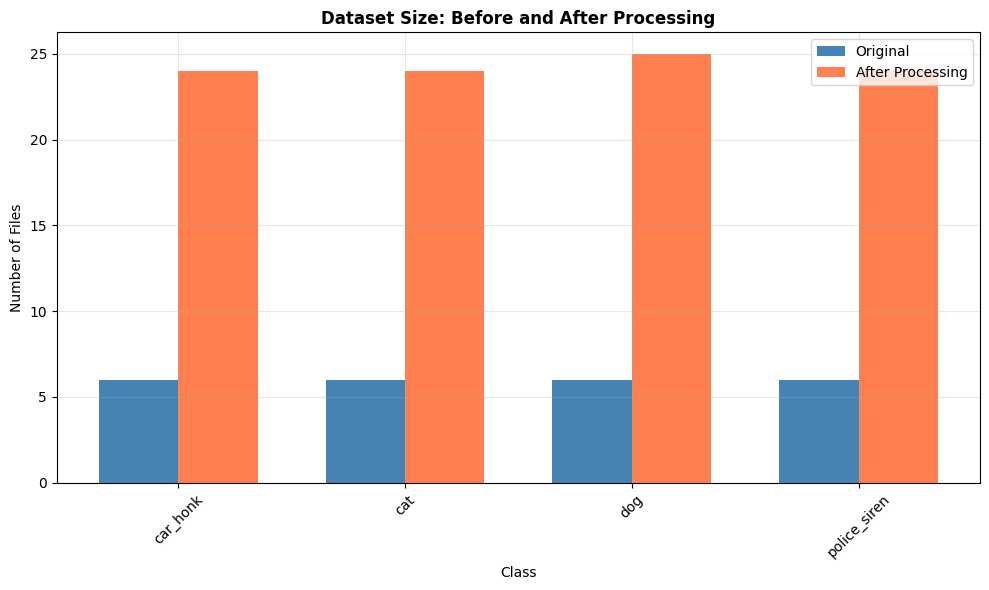


PREPROCESSING COMPLETE!

Processed files saved to: ../data/processed/
Dataset info saved to: ../data/processed/dataset_info.json

Next Step: Run 03_yamnet_embeddings.ipynb


In [15]:
print("\nConfiguration:")
print("- Target sample rate: 16kHz")
print("- Audio normalization: Enabled")
print("- Silence trimming: Enabled")
print("- Chunk duration: 5 seconds")
print("- Augmentation: Enabled (noise, time shift, pitch shift)")

dataset_info = process_dataset(
    input_dir='../data/raw',
    output_dir='../data/processed',
    apply_augmentation=True
)

# Save dataset info
with open('../data/processed/dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

# =========================
# 4. VISUALIZATION
# =========================

print("\n" + "="*60)
print("PREPROCESSING STATISTICS")
print("="*60)

for class_name in dataset_info['classes']:
    stats = dataset_info['statistics'][class_name]
    print(f"\n{class_name}:")
    print(f"  Original files: {stats['original_files']}")
    print(f"  Processed files: {stats['processed_files']}")
    print(f"  Augmentation factor: {stats['processed_files'] / stats['original_files']:.1f}x")

# Visualize before/after comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Select first class for visualization
first_class = dataset_info['classes'][0]
first_class_dir = os.path.join('../data/processed', first_class)
sample_files = os.listdir(first_class_dir)[:4]  # Get 4 samples

for idx, filename in enumerate(sample_files):
    ax = axes[idx // 2, idx % 2]
    filepath = os.path.join(first_class_dir, filename)
    y, sr = librosa.load(filepath, sr=16000)
    
    ax.plot(np.linspace(0, len(y)/sr, len(y)), y)
    ax.set_title(filename, fontsize=10)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Processed Audio Samples - {first_class}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Dataset size comparison
classes = dataset_info['classes']
original_counts = [dataset_info['statistics'][c]['original_files'] for c in classes]
processed_counts = [dataset_info['statistics'][c]['processed_files'] for c in classes]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, original_counts, width, label='Original', color='steelblue')
ax.bar(x + width/2, processed_counts, width, label='After Processing', color='coral')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Files')
ax.set_title('Dataset Size: Before and After Processing', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print(f"\nProcessed files saved to: ../data/processed/")
print(f"Dataset info saved to: ../data/processed/dataset_info.json")
print("\nNext Step: Run 03_yamnet_embeddings.ipynb")